### Unstructured Data Analysis for Policy
### Final Project Report
#### <name (id)><name (id)>
#### May 3, 2018

## Part (1) Collecting Data of Image Files
### (a) Bing Image Search (damaged and undamaged buildings)
First, we collected image files from Bing image search results using Web API (Bing Image Search API v7). The reason why we chose Bing instead of Google is that Google does not give us over 100 image files per keyword. The issue seems to remain unsolved. Although Bing provided us with more than 100 image files, the total number still did not reach 1,000. (Even we searched more popular words such as "cat" in this API, we could not obtain over 1,000 files.)  
In conclusion, we obatained approximately 300 pictures of damaged buildings and 500 pictures of undamaged buildings from Bing image search. In these files, only a few images do not appear to contain buildings, and most of the images appear to contain single building.

In [90]:
subscription_key = '859122352e0342e299ac923d58604c24' # This is my API key 
   # (Basically, you need to register Microsoft Azure and subscribe BingSearchAPIs to use API key.
   # The number of calls is limited to 1,000 per month.)

assert subscription_key
search_url = "https://api.cognitive.microsoft.com/bing/v7.0/images/search"

# Set search term as "single building" or "single collapsed building" for undamaged and damaged building
search_term = "single building" # to search images of undamaged buildings
#search_term = "Single collapsed building" # to search images of damaged buildings
count = 150 # number of images to get per attempt (max: 150)

In [91]:
# Extract image files (1st attempt of a loop)
import requests

headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
params  = {"count": count, "q": search_term, "offset": 0, "license": "any", "imageType": "photo"}  
response = requests.get(search_url, headers=headers, params=params)
response.raise_for_status()
search_results = response.json() # The search_results object contains the actual images along with rich metadata such as related items.

thumbnail_urls = []
content_urls = []
formats = []

for img in search_results["value"]:
    thumbnail_urls.append(img["thumbnailUrl"]) # extract and store the thumbnail URLS.
    content_urls.append(img["contentUrl"]) # extract and store the content URLS
    formats.append(img["encodingFormat"]) # extract and store the encoding formats

# the following code extracts total estimate matches.
total_num_files = search_results["totalEstimatedMatches"]

# the following code extracts the next offset ("The zero-based offset that indicates 
# the number of images to skip before returning images. The default is 0. 
# The offset should be less than (totalEstimatedMatches - count)")
offset = search_results["nextOffset"]

print("Total estimate matches (the number of images hit by the search term): ", total_num_files)
print("The next offset is", offset, ".")


while offset < total_num_files - count: 
    # Extract image files (2nd, 3rd, ..., and the last-1 attempt of the loop)
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
    params  = {"count": count, "q": search_term, "offset": offset, "license": "any", "imageType": "photo"}  
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    for img in search_results["value"]:
        thumbnail_urls.append(img["thumbnailUrl"])
        content_urls.append(img["contentUrl"])
        formats.append(img["encodingFormat"])
    offset = search_results["nextOffset"]
    print("The next offset is", offset, ".")
else: 
    count = total_num_files - offset - 1
    if count > 0: # Extract the remainig image files (the last attempt of the loop)
        headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
        params  = {"count": count, "q": search_term, "offset": offset, "license": "any", "imageType": "photo"}  
        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        search_results = response.json()
        for img in search_results["value"]:
            thumbnail_urls.append(img["thumbnailUrl"])
            content_urls.append(img["contentUrl"])
            formats.append(img["encodingFormat"])
        offset = search_results["nextOffset"]
        print("The next offset is", offset, "(this is the end point).")
    print("The total number of images obtained:", len(thumbnail_urls))

Total estimate matches (the number of images hit by the search term):  607
The next offset is 186 .
The next offset is 374 .
The next offset is 567 .
The next offset is 641 (this is the end point).
The total number of images obtained: 489


In [61]:
# you can check the content of each list
#thumbnail_urls
#content_urls
#formats

In [81]:
# Download the pictures to the same folder as this ipynb file (this will take some minutes)
for i, url in enumerate(thumbnail_urls): # if you want to download thumbnail files choose this line
#for i, url in enumerate(content_urls): # if you want to download content (full size) files choose this line
    fileName = str(i+1) + "." +formats[i]
    req = requests.get(url)
    f = open(fileName, 'wb')
    f.write(req.content)
    f.close()
    
##### NOTE: #####
# After downloading, you need to (create "undamaged" or "damaged" folder and) transfer these files into the folder manually.

The code below is just to show a few sample subsets of the collected images.

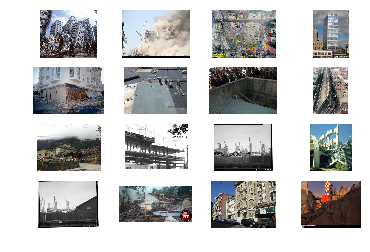

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
                  
f, axes = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        image_data = requests.get(thumbnail_urls[i+4*j])
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))        
        axes[i][j].imshow(image)
        axes[i][j].axis("off")

#### Reference List
- Microsoft Azure, "Image Search API v7 reference", https://docs.microsoft.com/en-us/rest/api/cognitiveservices/bing-images-api-v7-reference
- "Do you know why only 100 images is the limit? Can we have more than 100?", https://github.com/hardikvasa/google-images-download/issues/7

### (b) Natural Hazards Image Database (damaged buildings)
Second, we obtained images of damaged buildings from Natural Hazards Image Database where there are approximately 100 photos taken in the stricken areas by earthquakes such as the Great East Japan Earthquake in 2011. We used web scraping to obtain the data. In summary, we gained 83 image files in total. While most images contain damaged (collapsed) buildings, some of the pictures contain several (not single) buildings and a few pictures do not appear to contain buildings.

In [83]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time

In [86]:
## You can extract images of 2011 Honshu Japan Earthquake and Tsunami from the following code.
## (39 files from 'https://www.ngdc.noaa.gov/hazardimages/event/show/256')
r = requests.get('https://www.ngdc.noaa.gov/hazardimages/event/show/256') 

## You can also extract pictures of 2011 Christchurch New Zealand Earthquake (24 files)
## and 2010 Haiti Earthquake and Tsunami (20 files) by replacing the url above.

## New Zealand, 'https://www.ngdc.noaa.gov/hazardimages/event/show/259'
## Haiti, 'https://www.ngdc.noaa.gov/hazardimages/event/show/258'

page = r.content
soup = bs(page, "html.parser")

lists = soup.find_all("li", class_ = "")
links = []
for list in lists:
    link = list.img.get("src")
    links.append(link)
    
## Print the number of pictures and URLs
#print(len(links), links)

In [87]:
# Download the pictures stored in "lists"
for link in links:
    fileName = link.split("/")[-1]
    req = requests.get(link)
    f = open(fileName, 'wb')
    f.write(req.content)
    f.close()

##### NOTE #####
# After downloading, you need to transfer these files into the "damaged" folder manually.

#### Reference List
- "Natural Hazards Image Database", https://www.ngdc.noaa.gov/hazardimages/
- "Do you know why only 100 images is the limit? Can we have more than 100?", https://github.com/hardikvasa/google-images-download/issues/7

### (c) Other Sources
Finally, we acquired image data of undamaged buildings from The Oxford Building Dataset, which offers approximately 5,000 pictures collected from Flickr by searching for particular Oxford landmarks; however, many of the images are pictures of humans or pictures taken inside buildings. Thus, we decided not use this data.

#### Reference List
- James Philbin, Relja Arandjelović and Andrew Zisserman, "The Oxford Buildings Dataset", http://www.robots.ox.ac.uk/~vgg/data/oxbuildings/

## Part (2) Image Analysis (Establishing Models)
Using the collected images (383 image files of damaged buildings and 490 image files of undamaged buildings), we conducted image analysis to establish a model which can classify "damaged" and "undamaged" buildings.  
First, we resized images and flattened them to make it easier to analize. We labeled each image as "damaged" (y = 1) or "undamaged" (y = 0).  
Second, we splitted the images into a training set and a test set.  
Third, we conducted Principal Component Analysis (PCA) to reduce dimensions of image features. As the code below demonstrates, the first five principal components explain the variance well. Thus, we chose the number of components as five (5).  
Fourth, we used Support Vector Machine (SVM) classifier, k-Nearest Neighbor (k-NN) method, and Random Forest (RM) classifier. For each method, we performed 5-fold cross-validation to choose the best hyperparameter (C for SVM classifier, k for k-NN, and the numbe of trees for RM classifier).

In [128]:
from PIL import Image
import numpy as np
import os
import pandas as pd
import pylab as pl
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import glob

In [94]:
# Create functions to transform images

# Define the size after resizing
standard_size = (300, 167)

# Resize an image to the standard_size (shape = (300, 167, 3))
# and convert it numpy array of RGB pixels
def img_to_matrix(filename):
    img = Image.open(filename)
    img = img.resize(standard_size)
    img_array = np.array(img)
    return img_array

# Flatten a (m, n, l) numpy array into an array of shape (1, m * n * l)
def flatten_image(img):
    s = img.shape[0] * img.shape[1] * img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [120]:
# List each image files within "damaged" and "undamaged" folders in "image" folder 
# And label "damaged" to the files in "damaged" folder and "undamaged" to the files in "undamaged" folder 
images = []
labels = []

for image in glob.glob("./images/damaged/*.jpg"):
    images.append(image)
    labels.append("damaged")
for image in glob.glob("./images/damaged/*.jpeg"):
    images.append(image)
    labels.append("damaged")
for image in glob.glob("./images/damaged/*.gif"):
    images.append(image)
    labels.append("damaged")
for image in glob.glob("./images/damaged/*.png"):
    images.append(image)
    labels.append("damaged")
      
for image in glob.glob("./images/undamaged/*.jpg"):
    images.append(image)
    labels.append("undamaged")
for image in glob.glob("./images/undamaged/*.jpeg"):
    images.append(image)
    labels.append("undamaged")
for image in glob.glob("./images/undamaged/*.gif"):
    images.append(image)
    labels.append("undamaged")
for image in glob.glob("./images/undamaged/*.png"):
    images.append(image)
    labels.append("undamaged")

In [105]:
# Create a function to process the data (convert image files into a numpy array)
def data_processing(images, labels):         
    data = []
    
    for image in images:
        # Apply the created functions above
        img = img_to_matrix(image)
        img = flatten_image(img)
        data.append(img)
    # Convert "data" list into numpy array
    data = np.array(data)
    return data

In [106]:
# Check the explained variance ratio by PCA to determine the number of principal components
data = data_processing(images, labels)
pca = PCA()
pca.fit(data)
pca.explained_variance_ratio_[:20] # display only the first ten (20) principal components
# the result shows that the first principal component explains 19.2%,
# the second explains 9.6%, the third explains 5.6%, the fourth explains 4.4%,
# and the fifth explains 3.9% of the variance. Thus we chose the number of components as five (5).

array([0.19210446, 0.09584699, 0.05634368, 0.04380417, 0.03925011,
       0.0258439 , 0.01986203, 0.01720245, 0.01481091, 0.01422976,
       0.01254309, 0.01117685, 0.00933585, 0.00880592, 0.0082537 ,
       0.00724056, 0.00692399, 0.00638901, 0.00588678, 0.0058085 ])

In [121]:
# Divide data into a training set and a test set
data = data_processing(images, labels)
train_frac = 0.80
is_train = np.random.uniform(0, 1, len(data)) <= train_frac
# Convert labels into a binary (1 if damaged, otherwise 0)
y = np.where(np.array(labels) == 'damaged', 1, 0)
train_x, train_y = data[is_train], y[is_train]
## Set the test data
test_x, test_y = data[is_train == False], y[is_train == False]

print("The number of images of damaged buildings in total:", len(y[y==1]))
print("The number of images of undamaged buildings in total:", len(y[y==0]))
      
print("The number of training samples:", len(train_y))
print("The number of images of damaged buildings in the training samples:", len(train_y[train_y==1]))
print("The number of images of undamaged buildings in the training samples:", len(train_y[train_y==0]))

print("The number of test samples:", len(test_y))
print("The number of images of damaged buildings in the test samples:", len(test_y[test_y==1]))
print("The number of images of undamaged buildings in the test samples:", len(test_y[test_y==0]))

## Reduce demension to 5 principal components
pca = PCA(n_components = 5)
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

The number of images of damaged buildings in total: 379
The number of images of undamaged buildings in total: 488
The number of training samples: 720
The number of images of damaged buildings in the training samples: 306
The number of images of undamaged buildings in the training samples: 414
The number of test samples: 147
The number of images of damaged buildings in the test samples: 73
The number of images of undamaged buildings in the test samples: 74


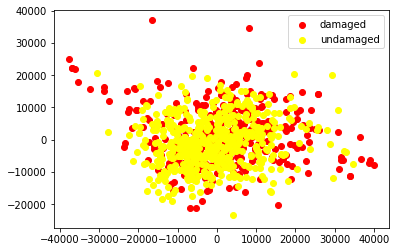

In [122]:
## Plot the 1st and 2nd principle components (this does not appear to be helpful)
pca = PCA(n_components=2)
X = pca.fit_transform(data)
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label": np.where(y == 1, 'damaged', 'undamaged')})
colors = ['red', 'yellow']
for label, color in zip(df['label'].unique(), colors):
    mask = df['label'] == label
    pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
pl.legend()

In [123]:
# (1) Conduct 10-fold cross-validation to choose the best C for SVM classifier
def CV_SVC(train_x, train_y):
    lowest_cross_val_error = np.inf
    best_C = None
    indices = range(len(train_x))
    kf = KFold(n_splits=10, shuffle=True, random_state=94775)
    for C in [1e-2, 1e-1, 1, 10, 100, 1000]:
        errors = []
        for train_indices, val_indices in kf.split(indices):
            classifier = LinearSVC(C=C)
            classifier.fit(train_x[train_indices], train_y[train_indices])
            predicted_val_labels = classifier.predict(train_x[val_indices])
            error = np.mean(predicted_val_labels != train_y[val_indices])
            errors.append(error)
        
        cross_val_error = np.mean(errors)
        print('C:', C, 'cross validation error:', cross_val_error)

        if cross_val_error < lowest_cross_val_error:
            lowest_cross_val_error = cross_val_error
            best_C = C

    print('Best C:', best_C, 'cross validation error:', lowest_cross_val_error)
    return best_C

In [124]:
# Evaluate the best SVM classifier

best_C = CV_SVC(train_x, train_y)

# Train a classifier with the best C 
# Fit a classifier to the "entire" training set
final_svm_classifier = LinearSVC(C=best_C)
final_svm_classifier.fit(train_x, train_y)

# Evaluate the model in the "unseen" test set
predicted_test_labels = final_svm_classifier.predict(test_x)
test_set_error = np.mean(predicted_test_labels != test_y)
print("Test_set_error of SVM classifier with the best C:", test_set_error)
# Create a confusion matrix
print("The confusion matrix is as follows:")
pd.crosstab(test_y, predicted_test_labels, rownames=['Actual'], colnames=['Predicted'])

C: 0.01 cross validation error: 0.44861111111111107
C: 0.1 cross validation error: 0.43194444444444446
C: 1 cross validation error: 0.4680555555555556
C: 10 cross validation error: 0.5250000000000001
C: 100 cross validation error: 0.4680555555555556
C: 1000 cross validation error: 0.5138888888888887
Best C: 0.1 cross validation error: 0.43194444444444446
Test_set_error of SVM classifier with the best C: 0.4217687074829932
The confusion matrix is as follows:


Predicted,0,1
Actual,,
0,42,32
1,30,43


In [126]:
# (2) Conduct 10-fold cross-validation to choose the best k for k-Nearest Neighbor
def CV_kNN(train_x, train_y):
    lowest_cross_val_error = np.inf
    best_k = None
    indices = range(len(train_x))
    kf = KFold(n_splits=10, shuffle=True, random_state=94775)
    for k in [3, 5, 15, 25, 50]:
        errors = []
        for train_indices, val_indices in kf.split(indices):
            classifier = KNeighborsClassifier(n_neighbors=k)
            classifier.fit(train_x[train_indices], train_y[train_indices])
            predicted_val_labels = classifier.predict(train_x[val_indices])
            error = np.mean(predicted_val_labels != train_y[val_indices])
            errors.append(error)
        
        cross_val_error = np.mean(errors)
        print('k:', k, 'cross validation error:', cross_val_error)

        if cross_val_error < lowest_cross_val_error:
            lowest_cross_val_error = cross_val_error
            best_k = k

    print('Best k:', best_k, 'cross validation error:', lowest_cross_val_error)
    return best_k

In [129]:
# Evaluate the best k-Nearest Neighbor model

best_k = CV_kNN(train_x, train_y)

# Train a classifier with the best C 
# Fit a classifier to the "entire" training set
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
final_knn_classifier.fit(train_x, train_y)

# Evaluate the model in the "unseen" test set
predicted_test_labels = final_knn_classifier.predict(test_x)
test_set_error = np.mean(predicted_test_labels != test_y)
print("Test_set_error of k-Nearest Neighbor with the best k:", test_set_error)
# Create a confusion matrix
print("The confusion matrix is as follows:")
pd.crosstab(test_y, predicted_test_labels, rownames=['Actual'], colnames=['Predicted'])

k: 3 cross validation error: 0.43888888888888883
k: 5 cross validation error: 0.4138888888888889
k: 15 cross validation error: 0.40555555555555556
k: 25 cross validation error: 0.4097222222222222
k: 50 cross validation error: 0.43194444444444446
Best k: 15 cross validation error: 0.40555555555555556
Test_set_error of k-Nearest Neighbor with the best k: 0.3877551020408163
The confusion matrix is as follows:


Predicted,0,1
Actual,,
0,58,16
1,41,32


In [131]:
# (3) Conduct 10-fold cross-validation to choose the best b for Random Forest classifier
def CV_RF(train_x, train_y):
    lowest_cross_val_error = np.inf
    best_b = None
    indices = range(len(train_x))
    kf = KFold(n_splits=10, shuffle=True, random_state=94775)
    for b in [50, 100, 150, 200, 250]:
        errors = []
        for train_indices, val_indices in kf.split(indices):
            classifier = RandomForestClassifier(n_estimators=b)
            classifier.fit(train_x[train_indices], train_y[train_indices])
            predicted_val_labels = classifier.predict(train_x[val_indices])
            error = np.mean(predicted_val_labels != train_y[val_indices])
            errors.append(error)
        
        cross_val_error = np.mean(errors)
        print('b:', b, 'cross validation error:', cross_val_error)

        if cross_val_error < lowest_cross_val_error:
            lowest_cross_val_error = cross_val_error
            best_b = b

    print('Best b:', best_b, 'cross validation error:', lowest_cross_val_error)
    return best_b

In [132]:
# Evaluate the best Random Forest model

best_b = CV_RF(train_x, train_y)

# Train a classifier with the best C 
# Fit a classifier to the "entire" training set
final_rf_classifier = RandomForestClassifier(n_estimators=best_b)
final_rf_classifier.fit(train_x, train_y)

# Evaluate the model in the "unseen" test set
predicted_test_labels = final_rf_classifier.predict(test_x)
test_set_error = np.mean(predicted_test_labels != test_y)
print("Test_set_error of Random Forest with the best b:", test_set_error)
# Create a confusion matrix
print("The confusion matrix is as follows:")
pd.crosstab(test_y, predicted_test_labels, rownames=['Actual'], colnames=['Predicted'])

b: 50 cross validation error: 0.4138888888888889
b: 100 cross validation error: 0.4180555555555555
b: 150 cross validation error: 0.4083333333333334
b: 200 cross validation error: 0.4138888888888889
b: 250 cross validation error: 0.4208333333333333
Best b: 150 cross validation error: 0.4083333333333334
Test_set_error of Random Forest with the best b: 0.3877551020408163
The confusion matrix is as follows:


Predicted,0,1
Actual,,
0,56,18
1,39,34


#### Reference List
- yhat, "Content-based image classification in Python", June 12, 2013, http://blog.yhat.com/posts/image-classification-in-Python.html

### (3) Performance Evaluation and Conclusion
We evaluated the models with the best hyperparameters by comparing each raw error rate in the unseen test set and selected the best classifier.
Then, we estimated the expected cost by the confusion matrix of the best classifier.
In conclusion, 